# CASA0009: Group Assignment

__Topic: An Investigation into the Biodiversity of England__

This set of base codes are meant to be used to pre-process source data from GBIF into output data for uploading onto the server and visualization on the website. Given the amount of source data that need to be pre-processed, we can 'chop' up different parts of the analysis to run on our own, before we stitch them together.

In [1]:
# install H3-Pandas for making hexes
#!pip install h3pandas

In [2]:
# install kneed to find knee in KNN plot
#!pip install kneed

In [3]:
# Load libraries

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import h3pandas
import os
import math
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from kneed import KneeLocator
import time
import seaborn as sns

In [4]:
# Create function to compute number of occurrences, species richness and species evenness (ref: https://sciencing.com/calculate-species-evenness-2851.html)
def cal_indicators(df):
    
    # Compute number of occurrences
    occ = len(df)
    
    # Compute  species richness
    sp_richness = len(df.speciesKey.unique().tolist())
    
    # Create frequency table of species
    df_out = df.groupby('speciesKey').count().reset_index()[['speciesKey', 'gbifID']].rename({'gbifID': 'Count'}, axis = 1)

    # Compute proportion of all species
    df_out['Proportion'] = df_out['Count'] / occ

    # Compute natural log of proportion
    df_out['ln_P'] = df_out['Proportion'].apply(math.log)

    # Compute P x In P
    df_out['P_ln_P'] = df_out['Proportion'] * df_out['ln_P']

    # Compute Shannon diversity index
    H = -sum(df_out['P_ln_P'])

    # Compute species evenness
    if sp_richness == 1:
        sp_evenness = 0
    else:
        sp_evenness = H / math.log(sp_richness)
    
    return occ, sp_richness, sp_evenness

## Output 1: Overview of Biodiversity in England

__To discuss: whether to use hexes or LAD for aggregation of point data - both suffers from MAUP, but LAD will have intuitive reference label. Will need to normalize by either area or population or both.__

### Load data

#### Source data from GBIF - occurrences in UK in Apr-May 2021

In [5]:
# Import data - note that there is only two months worth of data (April - May 2021) in UK. Download from OneDrive
pdf = pd.read_csv(os.path.join("Data", "UK_AprMay_2021.csv"), sep='\t', low_memory=False)

In [6]:
# Convert to geopanda dataframe
gdf = gpd.GeoDataFrame(pdf, 
      geometry=gpd.points_from_xy(pdf['decimalLongitude'], pdf['decimalLatitude'], crs='epsg:4326'))

In [7]:
# Re-project to BNG
gdf = gdf.to_crs("epsg:27700")

#### England outline map

In [8]:
# read in UK outlines (download from: https://geoportal.statistics.gov.uk/datasets/ons::countries-december-2021-uk-bgc/about)
UK_outline = gpd.read_file(os.path.join("Data", "Countries_(December_2021)_UK_BFC", "CTRY_DEC_2021_UK_BFC.shp"))

In [9]:
# Focus only on England
england = UK_outline[UK_outline.CTRY21NM == 'England']

In [10]:
# Spatial join to keep only occurrences within England
gdf = gpd.sjoin(gdf, england, op='within')

In [11]:
# Re-project back to WGS84 for H3
gdf = gdf.to_crs("epsg:4326")

### Process data

In [12]:
# Set resolution
resolution = 5

In [13]:
# Create hexes
gdf_h3 = gdf.h3.geo_to_h3(resolution)

# note that with this, index changes H3 hex id. Geometry remains as point.

In [14]:
# Reset index and rename columns
gdf_h3.reset_index(inplace = True)
gdf_h3.rename({"h3_0" + str(resolution): "h3_id"}, axis=1, inplace=True)

In [15]:
# create list to hold hex id, number of occurrences, species list, species richness and species evenness
hex_id = gdf_h3["h3_id"].unique().tolist()
occurrences = []
species_richness = []
species_evenness = []

In [16]:
# Compute indicators (occurrences, species richness and species evenness)

for i in hex_id:
    # segment out hex
    df = gdf_h3[gdf_h3["h3_id"] == i]
    
    # Compute indicators
    occ, sp_richness, sp_evenness = cal_indicators(df)
    
    # append values to list
    occurrences.append(occ)
    species_richness.append(sp_richness)
    species_evenness.append(sp_evenness)

In [17]:
# ADJUST THIS ACCORDINGLY!!

# Set year
year = 2021
year_list = [year] * len(hex_id)

In [18]:
# Create dataframe
df_ind = pd.DataFrame(list(zip(hex_id, year_list, occurrences, species_richness, species_evenness)), 
                      columns=['h3_id', 'year', 'occurrences', 'sp_richness', 'sp_evenness'])

In [19]:
# Get geometry of hex and convert to BNG

df_ind = df_ind.set_index('h3_id').h3.h3_to_geo_boundary().reset_index()
df_ind = df_ind.to_crs("epsg:27700")

In [20]:
df_ind

,h3_id,year,occurrences,sp_richness,sp_evenness,geometry
0,85194a8ffffffff,2021,1805,223,0.798218,"POLYGON ((565194.548 144254.584, 558241.016 13..."
1,851951b7fffffff,2021,11346,465,0.731998,"POLYGON ((383136.727 400978.006, 376071.075 39..."
2,85195d27fffffff,2021,4712,356,0.755069,"POLYGON ((497306.903 166387.158, 490288.682 16..."
3,85195d73fffffff,2021,4935,393,0.806094,"POLYGON ((450191.521 205269.711, 443135.507 19..."
4,85194ad3fffffff,2021,10410,532,0.707932,"POLYGON ((533981.376 184555.166, 527007.170 17..."
...,...,...,...,...,...,...
673,8519438bfffffff,2021,5,3,0.864974,"POLYGON ((518749.976 355612.483, 511814.006 35..."
674,851973cffffffff,2021,6,6,1.000000,"POLYGON ((380006.111 641340.700, 373020.393 63..."
675,851943bbfffffff,2021,9,2,0.918296,"POLYGON ((539443.604 328907.038, 532520.947 32..."
676,85195e37fffffff,2021,2,2,1.000000,"POLYGON ((318225.431 265302.408, 311049.410 25..."


In [22]:
# Save output
df_ind.to_csv('Output/Part1/df_ind_'+str(year)+'.csv', index=False)

Code for analysis on Python ends here. We will need to repeat this for all data from 2011 to 2021. Then we will stitch __df_ind__ together for uploading onto server.

Mapping below is just for sanity checks. Mapping and graphing should be coded directly on Javascript.

Graph could be occurrences, species richness, species evenness over the years (instead of radar chart, as per group pitch).

User can choose:
- Metric to display - map and graph will change accordingly
- Year (single year, instead of range of year) to display - map will change accordingly, while specific year can be highlighted (e.g. with a red 'halo') on the graph
- Hex/LAD to highlight - highlight hex/LAD on map (e.g. with a red 'halo')

Text(0.5, 1.0, 'Occurrences')

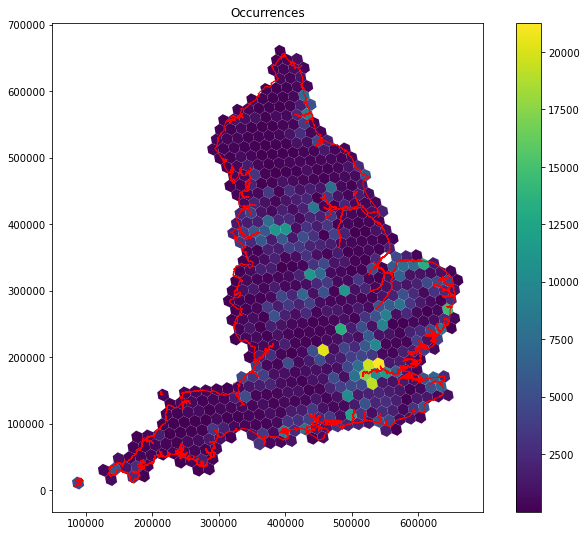

In [23]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

df_ind.plot(column='occurrences',ax=ax, legend=True)
england.plot(edgecolor='red', facecolor='none', ax=ax)
ax.set_title('Occurrences')

Text(0.5, 1.0, 'Species Richness')

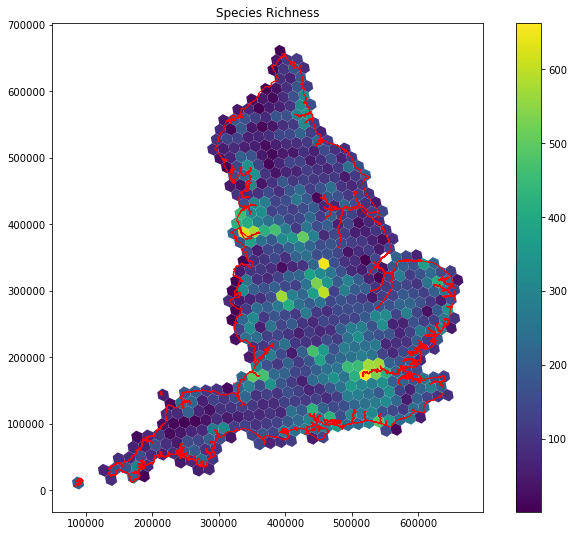

In [24]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

df_ind.plot(column='sp_richness',ax=ax, legend=True)
england.plot(edgecolor='red', facecolor='none', ax=ax)
ax.set_title('Species Richness')

Text(0.5, 1.0, 'Species Evenness')

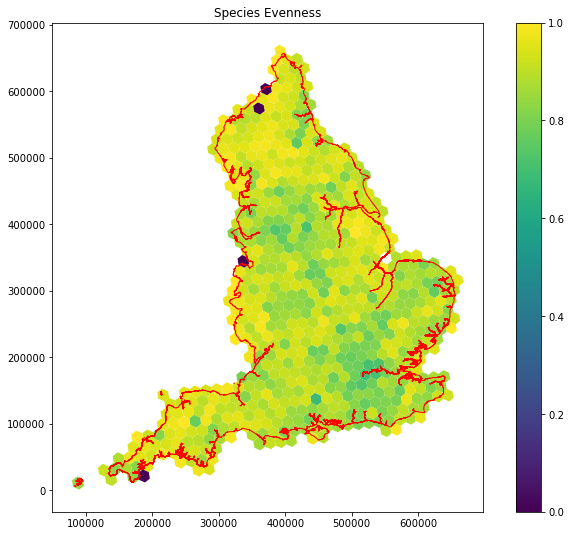

In [25]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

df_ind.plot(column='sp_evenness',ax=ax, legend=True)
england.plot(edgecolor='red', facecolor='none', ax=ax)
#nia.plot(edgecolor='blue', facecolor='none', ax=ax)
ax.set_title('Species Evenness')

## Output 3: Mapping of Endangered Species

### Load data

#### Source data from GBIF

In [26]:
# Import data - data from 2011 to 2021. Download from OneDrive
end_pdf = pd.read_csv(os.path.join("Data", "Endangered.csv"), sep='\t', low_memory=False)

In [27]:
# Convert to geopanda dataframe
end_gdf = gpd.GeoDataFrame(end_pdf, 
                           geometry=gpd.points_from_xy(end_pdf['decimalLongitude'], end_pdf['decimalLatitude'], 
                                                       crs='epsg:4326'))

In [28]:
# Re-project to BNG
end_gdf = end_gdf.to_crs("epsg:27700")

#### National Nature Reserves

In [29]:
# Load NNR
NNR = gpd.read_file(os.path.join("Data","NE_NationalNatureReservesEngland_SHP_Full","data","National_Nature_Reserves_England.shp"))

### Process data

In [30]:
year_count = end_pdf.groupby(['year', 'species']).size().reset_index(name='counts')

In [31]:
pd.unique(end_pdf.species)

array(['Puffinus mauretanicus', 'Vanellus gregarius', 'Betula pubescens',
       'Anguilla anguilla', 'Hadena bicruris', 'Calathus melanocephalus',
       'Aria whiteana', 'Lathyrus odoratus', 'Aria vexans',
       'Aria saxicola', 'Wollemia nobilis', 'Melhania ebena',
       'Polyscias racemosa', 'Castanea dentata', 'Ditrichum cornubicum',
       'Geranium maderense', 'Mustela lutreola', 'Calathus mollis',
       'Fraxinus americana', 'Fraxinus pennsylvanica', 'Aria evansii',
       'Cotoneaster cambricus', 'Hedlundia pseudofennica',
       'Lepidochelys kempii', 'Acipenser sturio'], dtype=object)

In [32]:
year_count

,year,species,counts
0,2011,Acipenser sturio,2
1,2011,Anguilla anguilla,557
2,2011,Aria whiteana,1
3,2011,Betula pubescens,647
4,2011,Calathus melanocephalus,28
...,...,...,...
110,2021,Geranium maderense,1
111,2021,Hadena bicruris,28
112,2021,Lathyrus odoratus,1
113,2021,Puffinus mauretanicus,213


In [33]:
# Save output
year_count.to_csv('Output/Part3/end_year_cnt.csv', index=False)
end_gdf.to_file('Output/Part3/endangered_gdf/endangered_gdf.shp')

/tmp/ipykernel_9733/1971302222.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  end_gdf.to_file('Output/Part3/endangered_gdf/endangered_gdf.shp')


Code for analysis on Python ends here. We will stitch upload __end_gdf__, __year_count__, and __NNR__ onto the server for visualization.

Mapping and graphing below is just for sanity checks. Mapping and graphing should be coded directly on Javascript:

User can choose:

- Year to display - map will change accordingly, while specific year can be highlighted (e.g. with a red 'halo') on the graph
- Species to display - map and graph will change accordingly
- NNR to highlight - NNR will be highlighted with a different color


<AxesSubplot:>

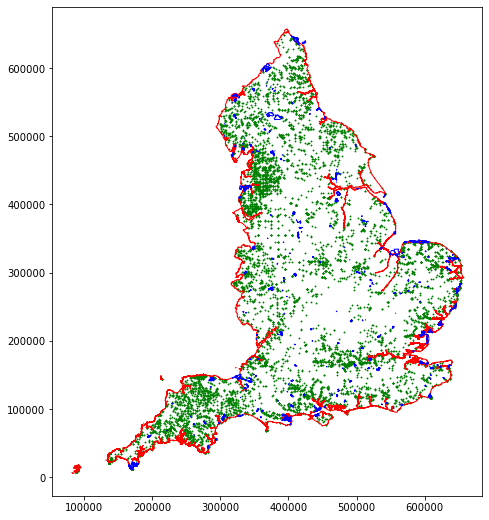

In [34]:
fig, ax = plt.subplots(1,1, figsize=(12,9))
end_gdf.plot(marker='*', color='green', markersize=1.0, ax=ax);
england.plot(edgecolor='red', facecolor='none', ax=ax)
NNR.plot(edgecolor='blue', facecolor='none', ax=ax)

Text(0, 0.5, 'Count')

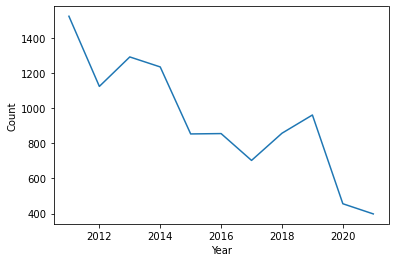

In [35]:
year_count_agg = year_count.groupby('year').agg({'counts': 'sum'}).reset_index()
plt.plot(year_count_agg.year, year_count_agg.counts)
plt.xlabel("Year")
plt.ylabel("Count")

## Output 2: Biodiversity Hotspots in London

I tried to run the analysis for 2 months' worth of data in England. However, I run into MemoryError when tryhing to find KNN - essentially, there's too many records and my device do not have enough memory to handle. So I suggest that we focus the analysis on London. We could, if we want, repeat the analysis city by city (or LAD by LAD), but I don't think that is necessary.

Another issue that I encountered was that, a lot of the data points have issues regarding rounding of coordinates. This creates a problem because many of the datapoints end up with the same coordinates, which means that we will get point hotspots, which really defeats the purpose.

As such, I suggest the following:

- Clean the dataset to remove those datapoints with issues
- Run the clustering to identify the hotspots
- Use full dataset to display

### Load data

#### Source data from GBIF - occurrences in London in 2021

In [36]:
# Import data - Download from OneDrive
ldn_pdf = pd.read_csv(os.path.join("Data", "London_2021.csv"), sep='\t', low_memory=False)

In [37]:
# Convert to geopanda dataframe
ldn_gdf = gpd.GeoDataFrame(ldn_pdf, 
                           geometry=gpd.points_from_xy(ldn_pdf['decimalLongitude'], ldn_pdf['decimalLatitude'], 
                                                       crs='epsg:4326'))

In [38]:
# Re-project to BNG
ldn_gdf = ldn_gdf.to_crs("epsg:27700")

#### London map

In [39]:
# Grab london map from FSDS for convenience - need to find proper map
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [40]:
# Dissolve boro boundaries
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
ldn = ldn.set_geometry('original')

In [41]:
# Spatial join!
ldn_gdf = gpd.sjoin(ldn_gdf, ldn, op='within')

### Clean data

In [42]:
# Take a look at the issues
pd.unique(ldn_gdf.issue)

array(['COORDINATE_ROUNDED', nan,
       'COORDINATE_ROUNDED;TAXON_MATCH_HIGHERRANK',
       'TAXON_MATCH_HIGHERRANK',
       'FOOTPRINT_WKT_INVALID;TAXON_MATCH_FUZZY', 'FOOTPRINT_WKT_INVALID',
       'INDIVIDUAL_COUNT_INVALID;COORDINATE_ROUNDED;TAXON_MATCH_FUZZY',
       'INDIVIDUAL_COUNT_INVALID;COORDINATE_ROUNDED',
       'INDIVIDUAL_COUNT_INVALID;FOOTPRINT_WKT_INVALID;TAXON_MATCH_FUZZY',
       'COORDINATE_ROUNDED;TAXON_MATCH_FUZZY',
       'COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84;INSTITUTION_MATCH_FUZZY;COLLECTION_MATCH_NONE',
       'GEODETIC_DATUM_ASSUMED_WGS84;TAXON_MATCH_HIGHERRANK;INSTITUTION_MATCH_FUZZY;COLLECTION_MATCH_NONE',
       'GEODETIC_DATUM_ASSUMED_WGS84;INSTITUTION_MATCH_FUZZY;COLLECTION_MATCH_NONE',
       'TYPE_STATUS_INVALID;COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84;INSTITUTION_MATCH_FUZZY;INSTITUTION_COLLECTION_MISMATCH',
       'GEODETIC_DATUM_ASSUMED_WGS84',
       'INDIVIDUAL_COUNT_INVALID;FOOTPRINT_WKT_INVALID',
       'GEODETIC_DATUM_ASSUMED_

In [43]:
# Remove those with issue "COORDINATE_ROUNDED"
ldn_gdf_cleaned = ldn_gdf.drop(ldn_gdf[(~ldn_gdf.issue.isna()) & (ldn_gdf.issue.str.contains('COORDINATE_ROUNDED'))].index)

In [44]:
# Check number of rows dropped
print(f'Number of occurrences before dropping: {len(ldn_gdf)}')
print(f'Number of occurrences after dropping: {len(ldn_gdf_cleaned)}')
print(f'Number (%) of occurrences dropped: {len(ldn_gdf)-len(ldn_gdf_cleaned)} ({(len(ldn_gdf)-len(ldn_gdf_cleaned))/len(ldn_gdf)*100:0.2f}%)')

Number of occurrences before dropping: 411131
Number of occurrences after dropping: 58797
Number (%) of occurrences dropped: 352334 (85.70%)


### Process data

#### First pass: OPTICS

##### Prep data

In [45]:
# Get x, y-coords
ldn_gdf_cleaned['x'] = ldn_gdf_cleaned.geometry.x
ldn_gdf_cleaned['y'] = ldn_gdf_cleaned.geometry.y

In [46]:
# Prep dataset for DBSCAN clustering
cdf = ldn_gdf_cleaned[['x','y']]

##### Set parameters - minPts and epsilon

In [47]:
# Set min number of points for a cluster - arbitrarily choose 1% of all occurrences
minPts = round(0.01*len(cdf))

In [48]:
# Nearest Neighbour. 
# Note that as we are using BNG, we can use Euclidean dist (instead of haversine method),
# and all distances are in metres.

tic = time.perf_counter()

nbrs = NearestNeighbors(n_neighbors=minPts).fit(cdf)
distances, indices = nbrs.kneighbors(cdf)

toc = time.perf_counter()
print(f"Completed in {toc - tic:0.4f} seconds")

Completed in 180.9892 seconds


In [49]:
distances = np.sort(distances[:,minPts-1], axis=0)

2940.1650795006103


<Figure size 360x360 with 0 Axes>

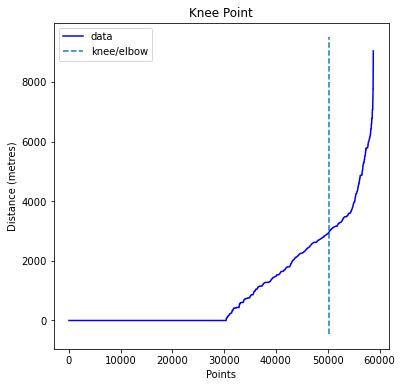

In [50]:
# Reference: https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance (metres)")

epsilon = distances[knee.knee]
print(epsilon)

##### Run OPTICS

In [51]:
tic = time.perf_counter()

opt = OPTICS(min_samples=minPts, max_eps=epsilon, metric = 'euclidean', n_jobs=-1)
opt.fit(cdf)

toc = time.perf_counter()
print(f"Completed in {toc - tic:0.4f} seconds")

Completed in 408.6446 seconds


/opt/conda/envs/sds2021/lib/python3.9/site-packages/sklearn/cluster/_optics.py:807: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [52]:
# Attach membership back to dataframe
ldn_gdf_cleaned['hotspot'] = opt.labels_

In [53]:
# Number of hotspots
print(f'Number of clusters: {len(pd.unique(ldn_gdf_cleaned.hotspot))-1}')

Number of clusters: 17


<AxesSubplot:>

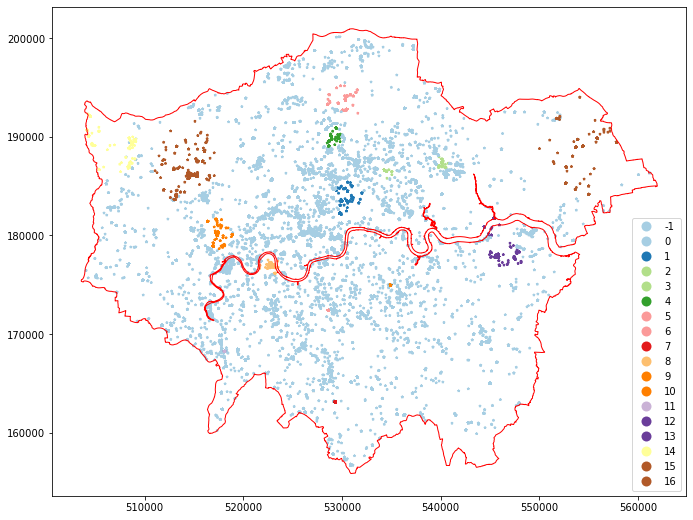

In [54]:
# Let's see where they are...

fig, ax = plt.subplots(1,1, figsize=(12,9))
ldn_gdf_cleaned.plot(column='hotspot', marker='*', markersize=5.0, categorical=True, legend=True, cmap='Paired', ax=ax);
ldn.plot(edgecolor='red', facecolor='none', ax=ax)

##### Draw convex hull around hotspots

In [55]:
# Create empty geodataframe
chull = gpd.GeoDataFrame(columns=['hotspot', 'convex_hull'])

for i in range(0, max(ldn_gdf_cleaned['hotspot'])+1):
    
    # retrieve occurrences in cluster
    convex_pt = ldn_gdf_cleaned[ldn_gdf_cleaned['hotspot'] == i]
    # create convex hull
    #hull = gpd.GeoSeries(data = convex_pt.unary_union.convex_hull, crs='epsg:27700')
    # add row to chull
    hull = gpd.GeoDataFrame(gpd.GeoSeries(data = convex_pt.unary_union.convex_hull, crs='epsg:27700')).rename(columns={0:chull.columns[1]})
    hull[chull.columns[0]] = i
    chull = chull.append(hull)
        
chull.reset_index().drop(columns='index', inplace = True)

chull = chull.set_geometry('convex_hull', crs='epsg:27700')

In [56]:
chull

,hotspot,convex_hull
0,0,"POLYGON ((527414.981 181484.953, 526608.184 18..."
0,1,"POLYGON ((529924.967 182094.990, 529757.883 18..."
0,2,"POLYGON ((534555.014 185784.965, 534296.355 18..."
0,3,"POLYGON ((540535.030 186845.048, 539774.967 18..."
0,4,"POLYGON ((528668.732 189047.031, 528509.527 18..."
0,5,"POLYGON ((531602.822 192375.731, 529896.878 19..."
0,6,POINT (528600.975 172379.884)
0,7,POINT (529301.467 163128.339)
0,8,"POLYGON ((523204.988 176095.039, 521649.966 17..."
0,9,"POLYGON ((517550.011 178650.027, 516936.802 17..."


In [57]:
# Hotspots 6, 7, 10 and 11 are points. Let's just remove them and re-number them.
chull.reset_index(drop=True, inplace=True)
chull.drop(chull[chull['hotspot'].isin([6, 7, 10, 11])].index, axis=0, inplace=True)
chull.reset_index(drop=True, inplace=True)
chull['hotspot'] = range(len(chull))

In [58]:
chull

,hotspot,convex_hull
0,0,"POLYGON ((527414.981 181484.953, 526608.184 18..."
1,1,"POLYGON ((529924.967 182094.990, 529757.883 18..."
2,2,"POLYGON ((534555.014 185784.965, 534296.355 18..."
3,3,"POLYGON ((540535.030 186845.048, 539774.967 18..."
4,4,"POLYGON ((528668.732 189047.031, 528509.527 18..."
5,5,"POLYGON ((531602.822 192375.731, 529896.878 19..."
6,6,"POLYGON ((523204.988 176095.039, 521649.966 17..."
7,7,"POLYGON ((517550.011 178650.027, 516936.802 17..."
8,8,"POLYGON ((544891.429 179874.482, 544424.224 18..."
9,9,"POLYGON ((545982.928 176924.774, 545923.286 17..."


<AxesSubplot:>

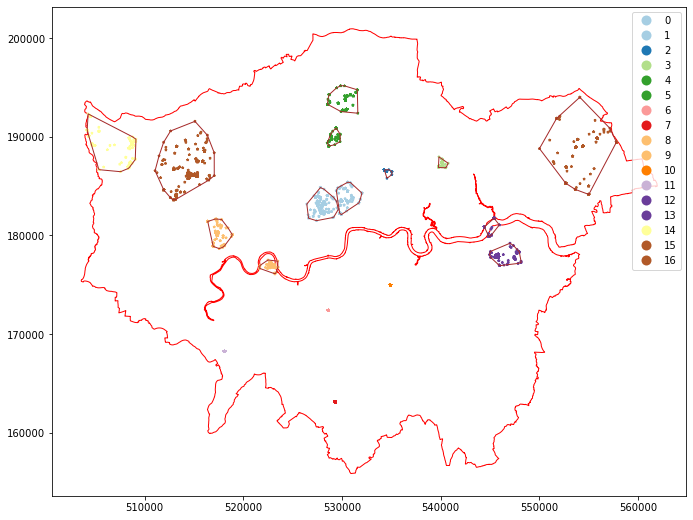

In [59]:
# Plot now
fig, ax = plt.subplots(1,1, figsize=(12,9))
ldn.plot(edgecolor='red', facecolor='none', ax=ax)
ldn_gdf_cleaned[ldn_gdf_cleaned.hotspot!=-1].plot(column='hotspot', marker='*', markersize=5.0, categorical=True, legend=True, cmap='Paired', ax=ax);
chull.plot(edgecolor='brown', facecolor='none', ax=ax)

In [60]:
# Save outputs
chull.to_file('Output/Part2/hotspots/hotspots.shp')

/tmp/ipykernel_9733/3685437078.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  chull.to_file('Output/Part2/hotspots/hotspots.shp')


Identification of hotspots end here. 

#### Second pass: KMeans clustering

##### Compute indicators for hotspots

In [61]:
# Spatial join to find the points within the clusters
ldn_hotspot = gpd.sjoin(ldn_gdf.drop(columns='index_right'), chull, op='intersects')

<AxesSubplot:>

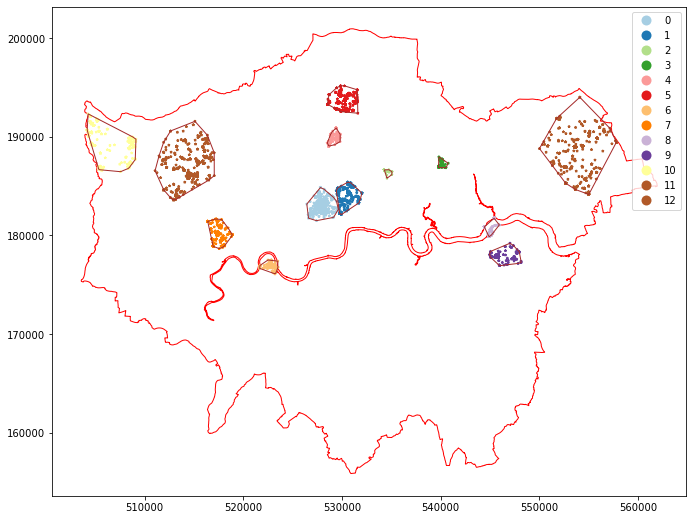

In [62]:
# Plot now to check
fig, ax = plt.subplots(1,1, figsize=(12,9))
ldn.plot(edgecolor='red', facecolor='none', ax=ax)
ldn_hotspot.plot(column='hotspot', marker='*', markersize=5.0, categorical=True, legend=True, cmap='Paired', ax=ax);
chull.plot(edgecolor='brown', facecolor='none', ax=ax)

In [63]:
# create list to hold hotspot id, number of occurrences, species list, species richness and species evenness
hotspot_id = chull.hotspot.tolist()
hotspot_occ = []
hotspot_sp_richness = []
hotspot_sp_evenness = []

In [64]:
# Compute indicators (occurrences, species richness and species eveness)

for i in hotspot_id:
    # segment out hex
    df = ldn_hotspot[ldn_hotspot['hotspot'] == i]
    
    # Compute indicators
    occ, sp_richness, sp_evenness = cal_indicators(df)
    
    # append values to list
    hotspot_occ.append(occ)
    hotspot_sp_richness.append(sp_richness)
    hotspot_sp_evenness.append(sp_evenness)

In [65]:
# CHANGE THIS ACCORDINGLY
year = '2021'

# Create dataframe
hotspot_ind = pd.DataFrame(list(zip(hotspot_id, hotspot_occ, hotspot_sp_richness, hotspot_sp_evenness)), 
                           columns=['hotspot', year+'_occ', year+'_sp_richness', year+'_sp_evenness'])

In [66]:
hotspot_ind

,hotspot,2021_occ,2021_sp_richness,2021_sp_evenness
0,0,4725,490,0.750720
1,1,3449,172,0.687045
2,2,624,48,0.863880
3,3,1028,118,0.797866
4,4,11346,131,0.666958
5,5,3937,186,0.773498
6,6,8536,190,0.818931
7,7,901,127,0.832489
8,8,808,122,0.882925
9,9,824,104,0.845555


In [67]:
# Save outputs
hotspot_ind.to_csv('Output/Part2/hotspot_ind_'+year+'.csv')

Computation of indicators for hotspots will need to be repeated from 2011 to 2021. The idea is that we will then have the indicator values for each year from 2011 to 2021, which we will then use for KMeans clustering.

KMeans clustering below is for demo purpose using only 2021 data.

In [68]:
var_col=[year+'_sp_richness', year+'_sp_evenness']
df_norm = hotspot_ind[var_col].copy()

In [69]:
# Normalization

scaler = MinMaxScaler()

for c in var_col:
    df_norm[c] = scaler.fit_transform(df_norm[c].values.reshape(-1,1))

##### Optimizing KMeans clustering

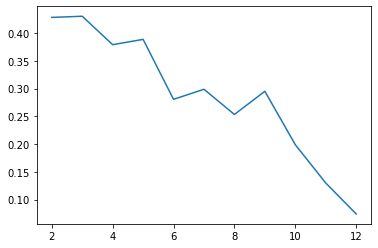

In [70]:
# Find optimal number of clusters

results = {'n':[], 'ss':[]}

for num_clusters in range(2,len(hotspot_ind)):
    
    # Do KMeans clustering
    kmeans_output = KMeans(n_clusters=num_clusters, n_init=10).fit(df_norm)
    
    # Calculate silhouette score
    clustering_ids_kmeans = kmeans_output.labels_
    silhouette_kmeans = silhouette_score(df_norm, clustering_ids_kmeans)
    
    results['n'].append(num_clusters)
    results['ss'].append(silhouette_kmeans)

plt.plot(results['n'], results['ss'])

In [71]:
# Optimal number clusters
opt_cluster=results['n'][np.argmax(results['ss'])]

##### KMeans clustering

In [72]:
# Run clustering with optimal number of clusters
kmeans_method = KMeans(n_clusters=opt_cluster, n_init=100).fit(df_norm)

In [73]:
# Attach membership back to dataframe
hotspot_ind['k_cluster'] = kmeans_method.labels_

In [74]:
# Merge datasets
hotspot_ind = pd.merge(chull, hotspot_ind, on='hotspot')

In [75]:
hotspot_ind

,hotspot,convex_hull,2021_occ,2021_sp_richness,2021_sp_evenness,k_cluster
0,0,"POLYGON ((527414.981 181484.953, 526608.184 18...",4725,490,0.750720,2
1,1,"POLYGON ((529924.967 182094.990, 529757.883 18...",3449,172,0.687045,0
2,2,"POLYGON ((534555.014 185784.965, 534296.355 18...",624,48,0.863880,1
3,3,"POLYGON ((540535.030 186845.048, 539774.967 18...",1028,118,0.797866,1
4,4,"POLYGON ((528668.732 189047.031, 528509.527 18...",11346,131,0.666958,0
5,5,"POLYGON ((531602.822 192375.731, 529896.878 19...",3937,186,0.773498,0
6,6,"POLYGON ((523204.988 176095.039, 521649.966 17...",8536,190,0.818931,1
7,7,"POLYGON ((517550.011 178650.027, 516936.802 17...",901,127,0.832489,1
8,8,"POLYGON ((544891.429 179874.482, 544424.224 18...",808,122,0.882925,1
9,9,"POLYGON ((545982.928 176924.774, 545923.286 17...",824,104,0.845555,1


<AxesSubplot:xlabel='2021_sp_richness', ylabel='2021_sp_evenness'>

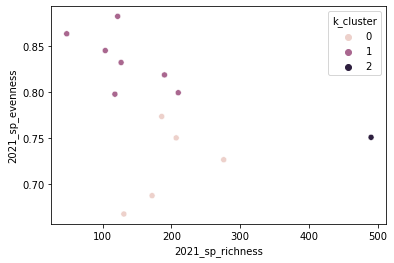

In [76]:
# Plot to see results of clustering
sns.scatterplot(x=year+'_sp_richness', y=year+'_sp_evenness', data=hotspot_ind, hue='k_cluster')

<AxesSubplot:>

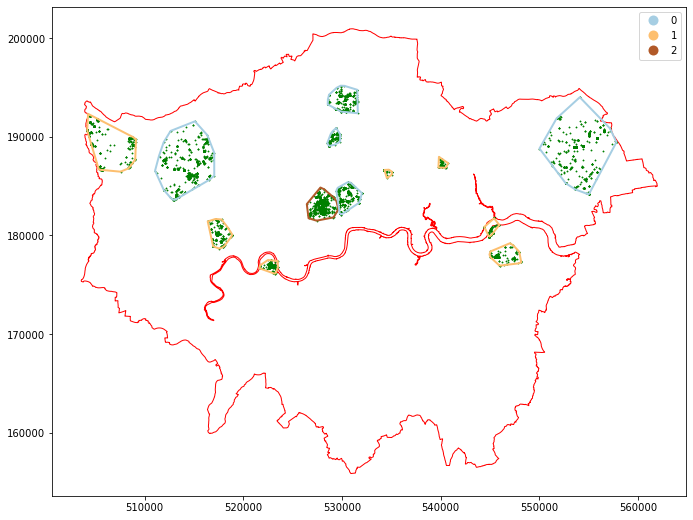

In [77]:
# Plot now to check
fig, ax = plt.subplots(1,1, figsize=(12,9))
ldn.plot(edgecolor='red', facecolor='none', ax=ax)
ldn_hotspot.plot(marker='*', color='green', markersize=1.0, ax=ax);
hotspot_ind.plot(column='k_cluster', facecolor='none', linewidth = 2.0, 
                 categorical = True, cmap = 'Paired', legend=True,ax=ax)

Code for analysis on Python ends here. We will upload __hotspot_ind__ onto the server for visualization. Can consider naming the hotspots and KMeans cluster  for easier identification.

For discussion: whether to upload the occurrences data from GBIF onto server for visualization also. If so, will need to clean up the df (which columns to drop, which to keep) and discuss how to stitch together.

Graph to show how metric (occurrences, species richness, species evenness) changed over the year.

Mapping and graphing above is just for sanity checks. Mapping and graphing should be coded directly on Javascript.

User can choose:

- Hotspot to highlight - Hotspot will be highlighted with a different color. Need to show the KMeans cluster somewhere.
- Metric to display - Specified metric to be shown on graph
- Year to display - Specified year to be highlighted (e.g. with a red 'halo') on the graph
